# 2. Обучение моделей


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from matplotlib import colors

In [9]:
data = pd.read_csv('../data/social_data.csv')

data.head()

,region,welfare_2015,welfare_2016,welfare_2017,welfare_2018,welfare_2019,welfare_2020,population_1999,population_2000,population_2001,...,to_underage_2021,to_underage_2022,foreign_2021,foreign_2022,cis_2021,cis_2022,migrant_2021,migrant_2022,illegal_2021,illegal_2022
0,Белгородская область,11.3,11.8,16.4,15.6,13.8,16.1,1494868.0,1501699.0,1506976.0,...,458,240,285,100,103,37,57,9,31,14
1,Брянская область,22.0,26.6,24.7,23.7,20.7,23.1,1437471.0,1423178.0,1407965.0,...,605,311,328,137,191,108,18,2,97,30
2,Владимирская область,18.1,18.0,24.0,23.4,23.4,26.0,1592184.0,1575507.0,1558052.0,...,536,261,272,134,229,105,65,19,22,11
3,Воронежская область,15.2,15.4,22.8,20.9,19.0,21.6,2458558.0,2441337.0,2422371.0,...,768,450,393,233,229,148,20,7,14,4
4,Ивановская область,18.1,28.9,28.7,27.0,25.1,25.1,1210603.0,1194595.0,1178969.0,...,470,229,102,138,72,132,1,14,0,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Columns: 560 entries, region to illegal_2022
dtypes: float64(472), int64(87), object(1)
memory usage: 372.0+ KB


In [11]:
data[data.isna().any(axis=1)]

,region,welfare_2015,welfare_2016,welfare_2017,welfare_2018,welfare_2019,welfare_2020,population_1999,population_2000,population_2001,...,to_underage_2021,to_underage_2022,foreign_2021,foreign_2022,cis_2021,cis_2022,migrant_2021,migrant_2022,illegal_2021,illegal_2022
31,Республика Крым,12.6,10.2,13.6,13.5,13.0,15.5,1909462.0,1909462.0,1909462.0,...,688,322,1020,474,172,75,2,3,15,5
36,г. Севастополь,12.2,10.5,13.3,14.1,13.2,13.3,439941.0,439941.0,439941.0,...,111,44,233,143,38,33,3,1,1,1


In [12]:
columns_with_nan = data.isna().any()
nan_columns = columns_with_nan[columns_with_nan].index.tolist()

nan_columns

['neoplasm_2011']

У нас пустая колонка со злокачественными опухолями в 2011 году, заполним ее 0

In [13]:
data = data.fillna(0)

Отрежем колонку с регионами, чтобы работать только с числами

In [14]:
numeric_data = data.iloc[:, 1:]

Создадим пайплайн, который производит стандартизацию признаков и выбирает только те колонки в которых уровень корреляции ниже 85%

In [15]:
pipe_pca = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components=0.8, random_state=42))])

pca_data = pipe_pca.fit_transform(numeric_data)

In [16]:
pca_data = pd.DataFrame(pca_data, index=numeric_data.index, columns=[f'column_{x}' for x in range(pca_data.shape[1])])

pca_data

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10
0,-2.886512,1.651718,-0.212723,4.059536,1.881479,-7.878495,8.151611,0.981231,0.947449,-1.169123,-2.395565
1,-5.108704,0.999261,1.772942,0.059772,1.165046,-1.969044,3.130022,-1.685269,-0.240410,-3.841991,-0.735288
2,-4.555386,1.653062,0.303708,-2.674011,4.552129,-2.051797,0.898296,0.476457,-4.291443,0.316320,0.831388
3,2.073355,-7.978928,-3.781784,-0.815513,-3.007553,-0.754977,1.277217,-2.822663,2.732473,-5.072523,1.517565
4,-7.954303,2.238888,0.947144,-3.488088,7.394526,-0.608287,1.578915,0.325090,-5.413435,-0.979329,2.762893
...,...,...,...,...,...,...,...,...,...,...,...
80,-4.713802,-2.426610,0.674376,-1.690850,-1.643120,4.098552,-3.325915,-1.021048,-0.024038,-2.774417,0.499317
81,-10.862936,4.121105,-12.329332,-4.540039,-3.889022,7.819924,2.395152,-6.328383,2.920519,7.500086,-1.596180
82,-6.527539,9.806470,-9.882989,-1.521794,-7.678701,9.119988,3.131171,-5.784444,8.328150,-2.634925,-0.356924
83,-11.705352,-6.327587,-6.643099,-4.350875,0.095513,8.837853,-7.851408,-1.718873,1.248806,-4.388100,4.764406


Получим 11 признаков

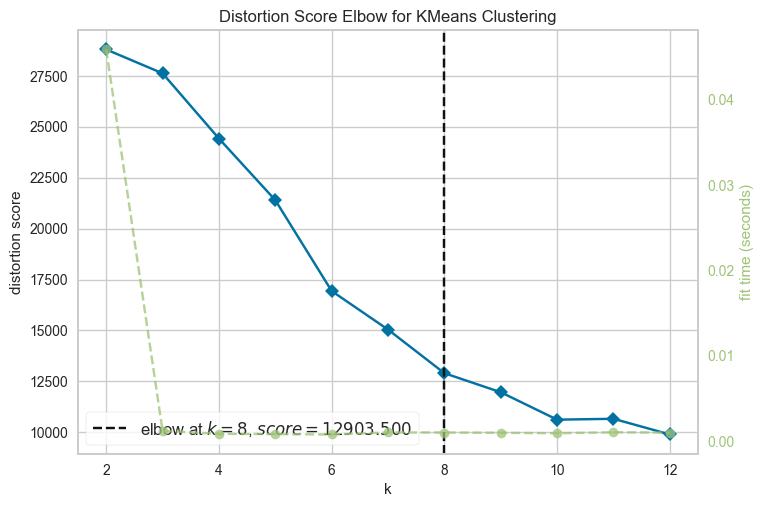

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
Elbow_pce = KElbowVisualizer(KMeans(random_state=42), k=12)
Elbow_pce.fit(pca_data)
Elbow_pce.show()

По методу локтя получаем 8 различных кластеров

In [18]:
model_data = data.copy()
model_pca = KMeans(n_clusters=8, random_state=42, init='k-means++')
y_pred = model_pca.fit_predict(pca_data)
model_data["Clusters_pca"]= y_pred

In [19]:
# Статистика по кластерам
cluster_profiles = model_data.iloc[:, 1:].groupby('Clusters_pca').median()
cluster_sizes = model_data.iloc[:, 1:]['Clusters_pca'].value_counts()

print("Размеры кластеров:")
print(cluster_sizes)

# Анализ наиболее проблемных регионов
poor_region = model_data[model_data['region'] == 'Республика Ингушетия'].index
poor_cluster = model_data.iloc[poor_region]['Clusters_pca'].values[0]
poor_regions = model_data[model_data['Clusters_pca'] == poor_cluster]

print(f"\nНаиболее проблемный кластер: {poor_cluster}")
print(f"Регионы в нем:\n{poor_regions['region']}")

Размеры кластеров:
Clusters_pca
2    32
3    28
1    15
6     3
7     3
0     2
4     1
5     1
Name: count, dtype: int64

Наиболее проблемный кластер: 6
Регионы в нем:
37     Республика Дагестан
38    Республика Ингушетия
42    Чеченская Республика
Name: region, dtype: object


Ориентируясь на Республику Ингушетию, как бедный регион мы получили еще 3 бедных региона.

Но мы получили слишком много кластеров. Большинство кластеров в итоге находятся в 3 разных отделах. Попробуем снизить кол-во признаков до 3, чтобы визуализировать полученные данные и уменьшить кол-во категорий.

In [20]:
pipe_pca_three = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components=3, random_state=42))])

pca_three_data = pipe_pca_three.fit_transform(numeric_data)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/pyth

In [21]:
pca_three_data = pd.DataFrame(pca_three_data, index=numeric_data.index, columns=[f'column_{x}' for x in range(pca_three_data.shape[1])])

pca_three_data

,column_0,column_1,column_2
0,-2.886512,1.651718,-0.212723
1,-5.108704,0.999261,1.772942
2,-4.555386,1.653062,0.303708
3,2.073355,-7.978928,-3.781784
4,-7.954303,2.238888,0.947145
...,...,...,...
80,-4.713802,-2.426610,0.674376
81,-10.862936,4.121105,-12.329332
82,-6.527539,9.806470,-9.882988
83,-11.705352,-6.327587,-6.643099


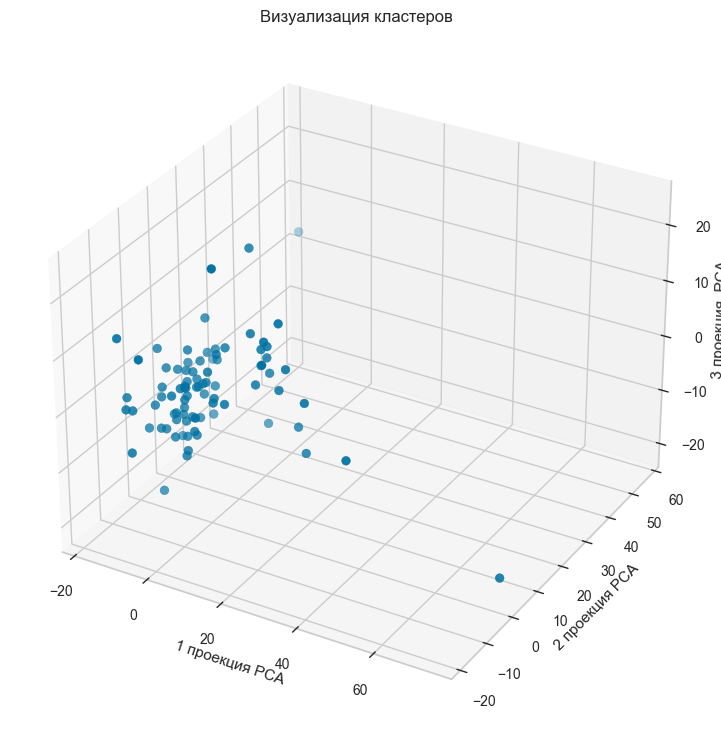

In [22]:
cmap = colors.ListedColormap(["y","g", "b","r", 'cyan'])

fig = plt.figure(figsize=(10,9))
ax = plt.subplot(111, projection='3d')
ax.scatter(pca_three_data.iloc[:,0], pca_three_data.iloc[:,1], pca_three_data.iloc[:,2], s=40, marker='o')
ax.set_title("Визуализация кластеров")
ax.set_xlabel('1 проекция PCA')
ax.set_ylabel('2 проекция PCA')
ax.set_zlabel('3 проекция  PCA')
plt.show()

После визуализации можно заметить полученный выброс, какой то из регионов слишком выделяется

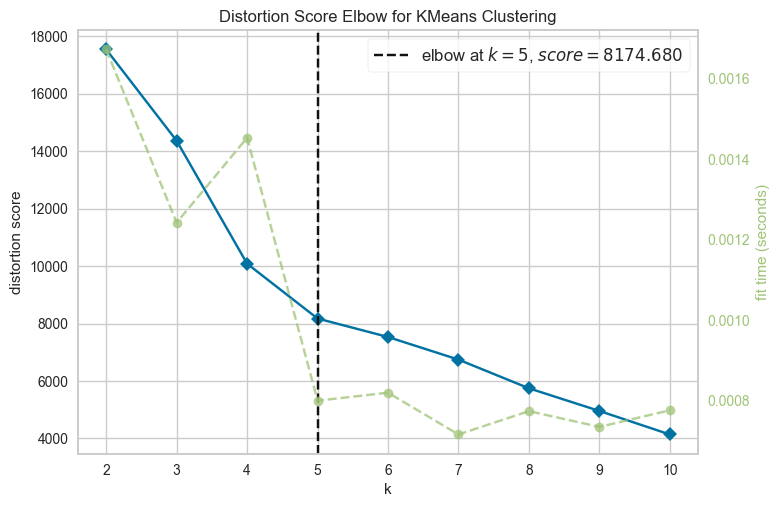

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
Elbow_pce_three = KElbowVisualizer(KMeans(random_state=42), k=10)
Elbow_pce_three.fit(pca_three_data)
Elbow_pce_three.show()

Нам удалось снизить кол-во категорий до 5

In [24]:
model_pca_three = KMeans(n_clusters=5, random_state=42, init='k-means++')
y_pred = model_pca_three.fit_predict(pca_three_data)
model_data["Clusters_pca_three"]= y_pred
pca_three_data["Clusters"] = y_pred


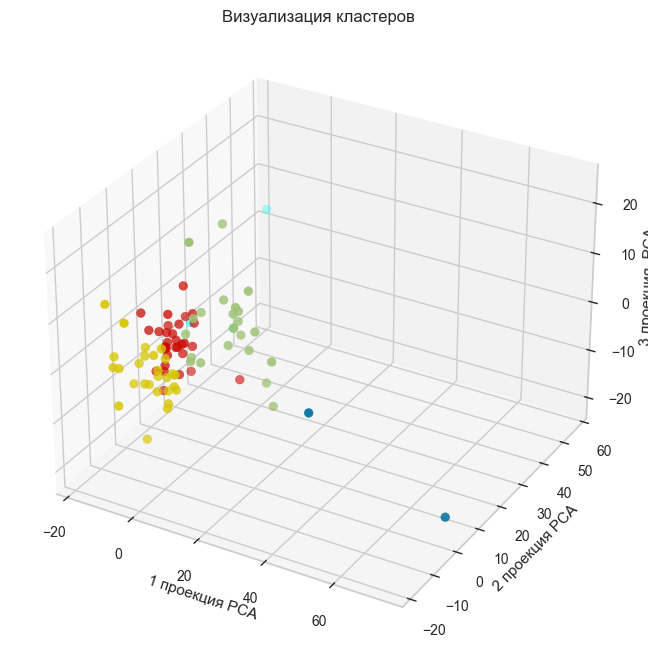

In [25]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
ax.scatter(pca_three_data.iloc[:,0], pca_three_data.iloc[:,1], pca_three_data.iloc[:,2], s=40, c=pca_three_data["Clusters"],cmap=cmap, marker='o')
ax.set_title("Визуализация кластеров")
ax.set_xlabel('1 проекция PCA')
ax.set_ylabel('2 проекция PCA')
ax.set_zlabel('3 проекция  PCA')
plt.show()

По рисунку видим что в 2 из 5 категорий попали всего лишь несколько регионов

In [26]:
# Статистика по кластерам
cluster_profiles = model_data.iloc[:, 1:].groupby('Clusters_pca_three').median()
cluster_sizes = model_data.iloc[:, 1:]['Clusters_pca_three'].value_counts()

print("Размеры кластеров:")
print(cluster_sizes)

# Анализ наиболее проблемных регионов
poor_region = model_data[model_data['region'] == 'Республика Ингушетия'].index
poor_cluster = model_data.iloc[poor_region]['Clusters_pca_three'].values[0]
poor_regions = model_data[model_data['Clusters_pca_three'] == poor_cluster]

print(f"\nНаиболее проблемный кластер: {poor_cluster}")
print(f"Регионы в нем:\n{poor_regions['region']}")

Размеры кластеров:
Clusters_pca_three
3    31
0    27
1    22
4     3
2     2
Name: count, dtype: int64

Наиболее проблемный кластер: 0
Регионы в нем:
3                   Воронежская область
5                     Калужская область
6                   Костромская область
7                       Курская область
8                      Липецкая область
11                    Рязанская область
13                   Тамбовская область
15                     Тульская область
23                Ленинградская область
26                    Псковская область
29                    Республика Адыгея
30                  Республика Калмыкия
31                      Республика Крым
36                       г. Севастополь
38                 Республика Ингушетия
39      Кабардино-Балкарская Республика
40      Карачаево-Черкесская Республика
41    Республика Северная Осетия-Алания
42                 Чеченская Республика
43                  Ставропольский край
46                  Республика Мордовия
51       

Теперь в наш кластер попало 27 регионов.

Попробуем для снижения размерности использовать TSNE, так как наши параметры не сильно зависят друг от друга.

In [27]:
pipe_tsne = Pipeline([('scale', StandardScaler()), ('tsne', TSNE(perplexity=50, random_state=42))])

tsne_data = pipe_tsne.fit_transform(numeric_data)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/pyth

<Axes: xlabel='axis-1', ylabel='axis-2'>

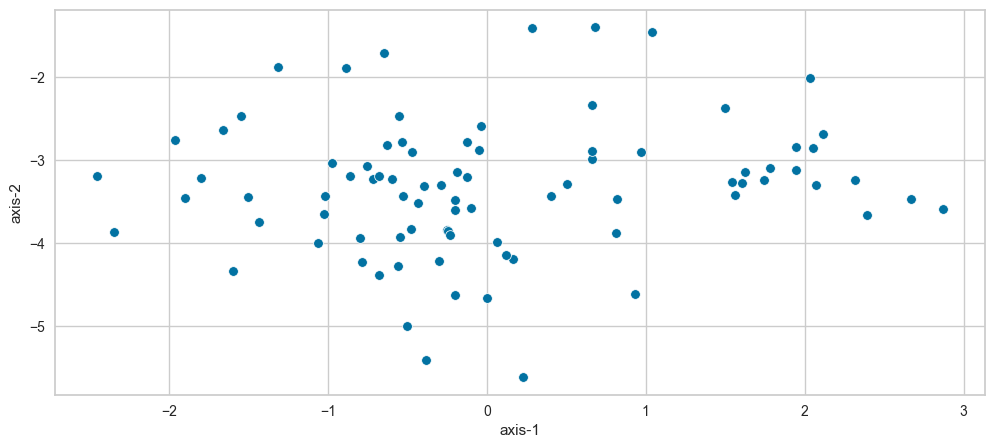

In [28]:
tsne_data = pd.DataFrame(tsne_data,
                index = data.index, 
                columns=['axis-1', 'axis-2']
                )

fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=tsne_data, x='axis-1', y='axis-2')

У нас получилось разделение без сильно выделяющихся точек

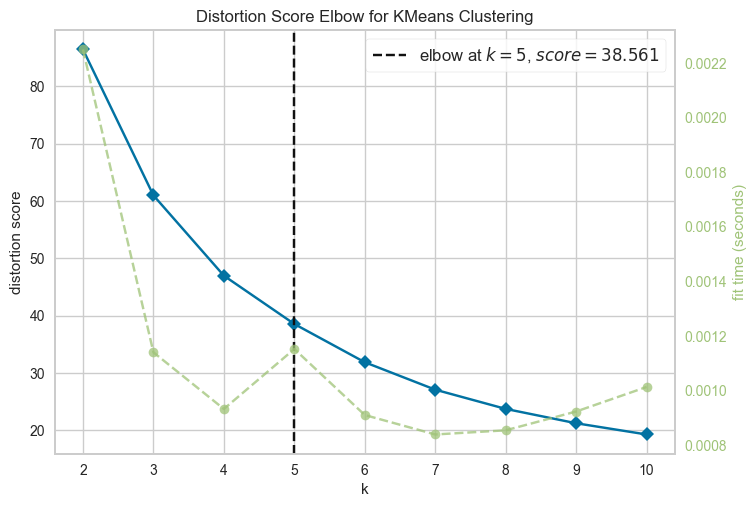

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
Elbow_tsne = KElbowVisualizer(KMeans(random_state=42), k=10)
Elbow_tsne.fit(tsne_data)
Elbow_tsne.show()

Все также выделяем 5 кластеров

In [30]:
model_tsne = KMeans(n_clusters=5, random_state=42, init='k-means++')
y_pred = model_tsne.fit_predict(tsne_data)
model_data["Clusters_tsne"]= y_pred

<Axes: xlabel='axis-1', ylabel='axis-2'>

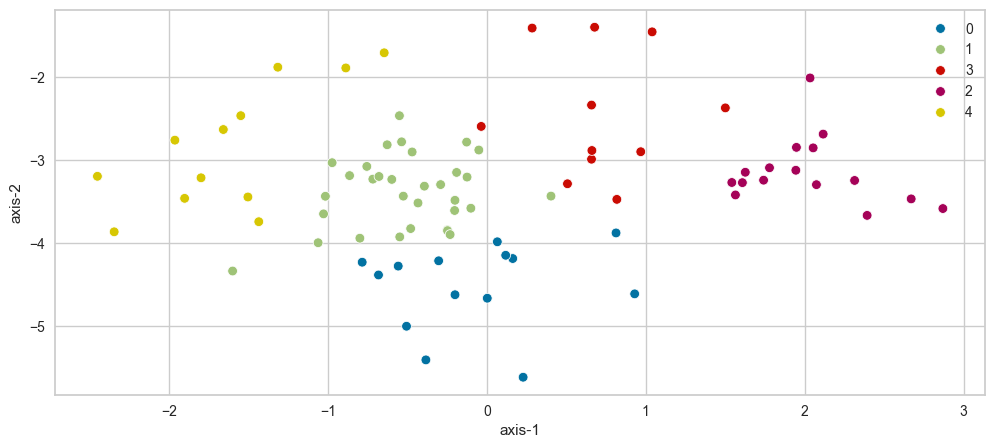

In [31]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=tsne_data, x='axis-1', y='axis-2', hue=model_tsne.labels_.astype('str'))

Разделения получились более равномерные

In [32]:
# Статистика по кластерам
cluster_profiles = model_data.iloc[:, 1:].groupby('Clusters_tsne').median()
cluster_sizes = model_data.iloc[:, 1:]['Clusters_tsne'].value_counts()

print("Размеры кластеров:")
print(cluster_sizes)

# Анализ наиболее проблемных регионов
poor_region = model_data[model_data['region'] == 'Республика Ингушетия'].index
poor_cluster = model_data.iloc[poor_region]['Clusters_tsne'].values[0]
poor_regions = model_data[model_data['Clusters_tsne'] == poor_cluster]

print(f"\nНаиболее проблемный кластер: {poor_cluster}")
print(f"Регионы в нем:\n{poor_regions['region']}")


Размеры кластеров:
Clusters_tsne
1    32
2    16
0    14
4    12
3    11
Name: count, dtype: int64

Наиболее проблемный кластер: 4
Регионы в нем:
29                    Республика Адыгея
30                  Республика Калмыкия
36                       г. Севастополь
38                 Республика Ингушетия
39      Кабардино-Балкарская Республика
40      Карачаево-Черкесская Республика
41    Республика Северная Осетия-Алания
42                 Чеченская Республика
65                      Республика Тыва
81                  Магаданская область
82                  Сахалинская область
83         Еврейская автономная область
Name: region, dtype: object


Получаем список и 12 бедных регионов. Как и в случае с нашим ручным анализом в список входят Республика Ингушетия, Тыва и Кабардино-Балкарская республика. Что подтвеждает правильность списка.

In [33]:
# Сравнение с средними по стране
national_avg_income = numeric_data['income_2020'].median()
national_avg_poverty = numeric_data['poverty_2020'].median()
poor_regions_data = poor_regions.copy()

poor_regions_data['income_diff'] = (poor_regions_data['income_2020'] - national_avg_income) / national_avg_income * 100
poor_regions_data['poverty_diff'] = (poor_regions_data['poverty_2020'] - national_avg_poverty) / national_avg_poverty * 100

poor_regions_data[['region', 'income_diff', 'poverty_diff']]


,region,income_diff,poverty_diff
29,Республика Адыгея,5.934396,-3.846154
30,Республика Калмыкия,-30.721080,74.615385
36,г. Севастополь,4.759407,-100.000000
38,Республика Ингушетия,-40.981256,130.769231
39,Кабардино-Балкарская Республика,-23.216534,86.153846
40,Карачаево-Черкесская Республика,-33.735487,78.461538
41,Республика Северная Осетия-Алания,-16.327458,6.923077
42,Чеченская Республика,-13.987970,56.923077
65,Республика Тыва,-33.655057,143.846154
81,Магаданская область,147.810883,-33.076923


Видим, что уровень бедности у Севастороля -100 что говорит, о том что регион не такой уж и бедный. А также уровеь ЗП не сильно влияет на бедность региона, так как сюда попали Магадан и Сахалин с хорошими ЗП.

### GaussianMixture


Попробуем другие модели на нашем датасете

In [34]:
model_gausian = GaussianMixture(n_components=5, random_state=42)
y_pred = model_gausian.fit_predict(tsne_data)
model_data["Clusters_gaus"]= y_pred

<Axes: xlabel='axis-1', ylabel='axis-2'>

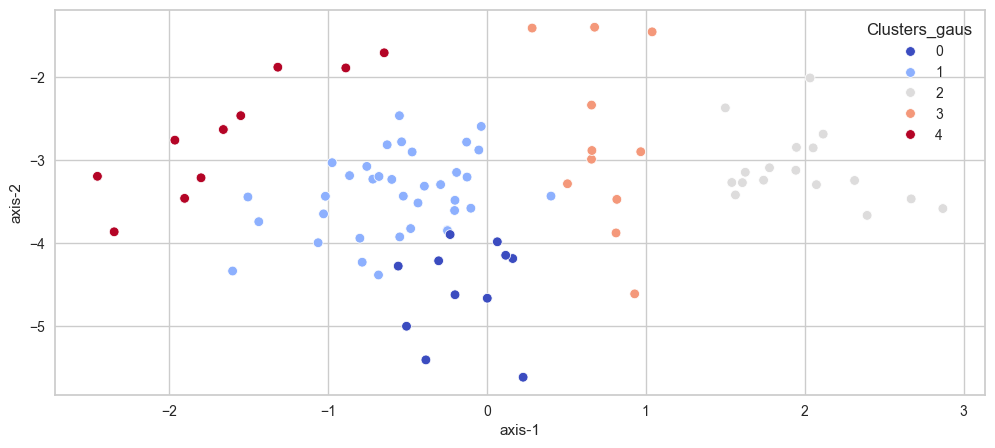

In [35]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=tsne_data, x='axis-1', y='axis-2', hue=model_data['Clusters_gaus'], palette="coolwarm")

In [36]:
# Статистика по кластерам
cluster_profiles = model_data.iloc[:, 1:].groupby('Clusters_gaus').median()
cluster_sizes = model_data.iloc[:, 1:]['Clusters_gaus'].value_counts()

print("Размеры кластеров:")
print(cluster_sizes)

# Анализ наиболее проблемных регионов
poor_region = model_data[model_data['region'] == 'Республика Ингушетия'].index
poor_cluster = model_data.iloc[poor_region]['Clusters_gaus'].values[0]
poor_regions = model_data[model_data['Clusters_gaus'] == poor_cluster]

print(f"\nНаиболее проблемный кластер: {poor_cluster}")
print(f"Регионы в нем:\n{poor_regions['region']}")

Размеры кластеров:
Clusters_gaus
1    36
2    17
0    11
3    11
4    10
Name: count, dtype: int64

Наиболее проблемный кластер: 4
Регионы в нем:
30                Республика Калмыкия
36                     г. Севастополь
38               Республика Ингушетия
39    Кабардино-Балкарская Республика
40    Карачаево-Черкесская Республика
42               Чеченская Республика
65                    Республика Тыва
81                Магаданская область
82                Сахалинская область
83       Еврейская автономная область
Name: region, dtype: object


Гаусовская модель выделила лишь 10 бедных регионов

In [37]:
# Сравнение с средними по стране
national_avg_income = numeric_data['income_2020'].median()
national_avg_poverty = numeric_data['poverty_2020'].median()
poor_regions_data = poor_regions.copy()

poor_regions_data['income_diff'] = (poor_regions_data['income_2020'] - national_avg_income) / national_avg_income * 100
poor_regions_data['poverty_diff'] = (poor_regions_data['poverty_2020'] - national_avg_poverty) / national_avg_poverty * 100

poor_regions_data[['region', 'income_diff', 'poverty_diff']]

,region,income_diff,poverty_diff
30,Республика Калмыкия,-30.721080,74.615385
36,г. Севастополь,4.759407,-100.000000
38,Республика Ингушетия,-40.981256,130.769231
39,Кабардино-Балкарская Республика,-23.216534,86.153846
40,Карачаево-Черкесская Республика,-33.735487,78.461538
42,Чеченская Республика,-13.987970,56.923077
65,Республика Тыва,-33.655057,143.846154
81,Магаданская область,147.810883,-33.076923
82,Сахалинская область,112.512239,-40.769231
83,Еврейская автономная область,-1.916352,81.538462


Из списка были исключены Адыгея и Северная Осетия

### DBSCAN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

<Axes: xlabel='cluster', ylabel='silhouette'>

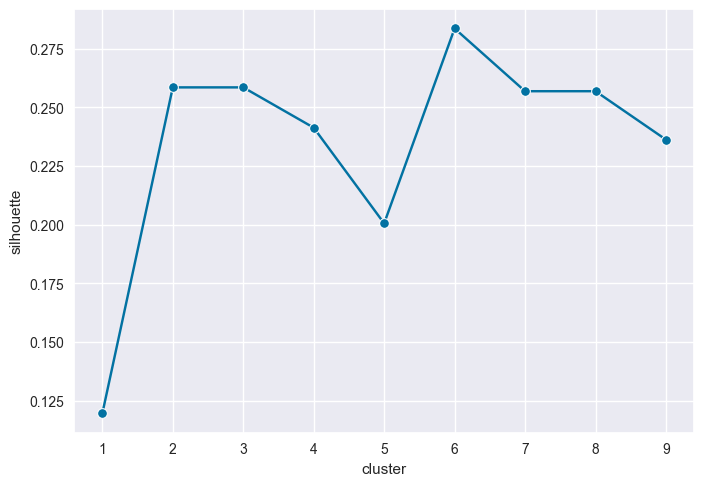

In [38]:
def get_scan_silhouette(cluster_num, X):
    dbscan = DBSCAN(min_samples=cluster_num, eps=0.5)
    dbscan.fit(X)
    
    silhouette = silhouette_score(X, dbscan.fit_predict(X))
    return silhouette

silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(1,10):
    silhouette_res["silhouette"].append(get_scan_silhouette(cluster_num, tsne_data))
    silhouette_res["cluster"].append(cluster_num)
    
silhouette_df = pd.DataFrame(silhouette_res)

sns.set_style("darkgrid")
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

По коэффициенту силуэта выделим 6 сэмплов для DBSCAN

In [39]:
model_db= DBSCAN(min_samples=6, eps=0.5)
y_pred = model_db.fit_predict(tsne_data)
model_data["Clusters_db"]= y_pred

<Axes: xlabel='axis-1', ylabel='axis-2'>

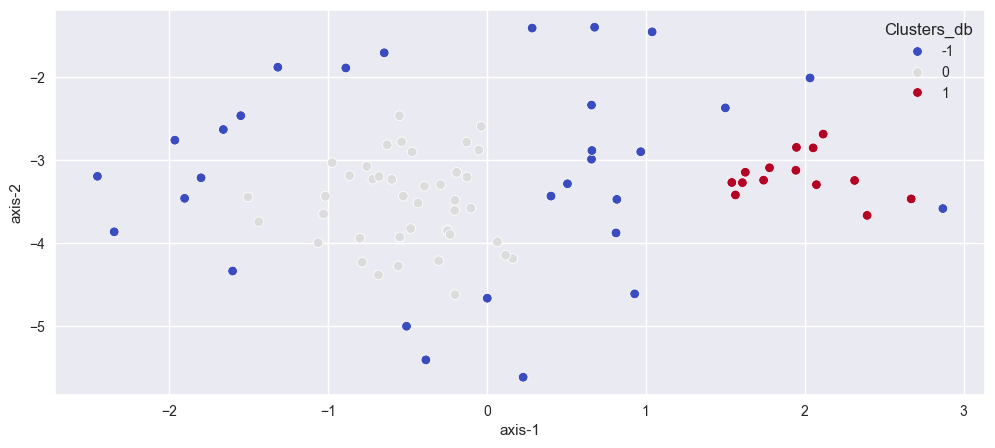

In [40]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=tsne_data, x='axis-1', y='axis-2', hue=model_data['Clusters_db'], palette='coolwarm')

DBSCAN выделил 3 категории

In [41]:
# Статистика по кластерам
cluster_profiles = model_data.iloc[:, 1:].groupby('Clusters_db').median()
cluster_sizes = model_data.iloc[:, 1:]['Clusters_db'].value_counts()

print("Размеры кластеров:")
print(cluster_sizes)

# Анализ наиболее проблемных регионов
poor_region = model_data[model_data['region'] == 'Республика Ингушетия'].index
poor_cluster = model_data.iloc[poor_region]['Clusters_db'].values[0]
poor_regions = model_data[model_data['Clusters_db'] == poor_cluster]

print(f"\nНаиболее проблемный кластер: {poor_cluster}")
print(f"Регионы в нем:\n{poor_regions['region']}")

Размеры кластеров:
Clusters_db
 0    41
-1    30
 1    14
Name: count, dtype: int64

Наиболее проблемный кластер: -1
Регионы в нем:
17                          г. Москва
28          Ненецкий автономный округ
30                Республика Калмыкия
31                    Республика Крым
34              Волгоградская область
36                     г. Севастополь
37                Республика Дагестан
38               Республика Ингушетия
39    Кабардино-Балкарская Республика
40    Карачаево-Черкесская Республика
42               Чеченская Республика
43                Ставропольский край
48              Удмуртская Республика
49               Чувашская Республика
53               Оренбургская область
56                Саратовская область
60                  Тюменская область
62                Ханты-Мансийский АО
63                  Ямало-Hенецкий АО
64                   Республика Алтай
65                    Республика Тыва
67                     Алтайский край
71              Новосибирская об

DBSCAN нам не подходит, так как Москва и Ингушетия оказались в одном кластере, что определенно неправильно

### AgglomerativeClustering

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

<Axes: xlabel='cluster', ylabel='silhouette'>

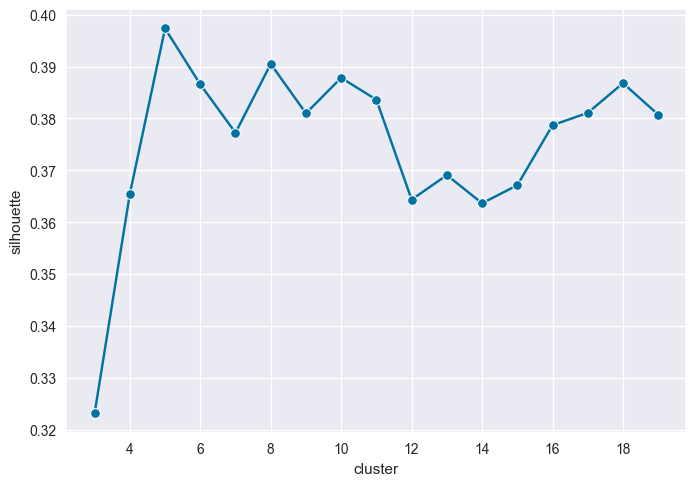

In [42]:
def get_scan_silhouette(cluster_num, X):
    aglo = AgglomerativeClustering(n_clusters=cluster_num)
    aglo.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, aglo.fit_predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(3, 20):
    silhouette_res["silhouette"].append(get_scan_silhouette(cluster_num, tsne_data))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

Получаем 5 кластеров

In [43]:
model_agg = AgglomerativeClustering(n_clusters=5).fit(tsne_data)
clustering_aglo = model_agg.fit_predict(tsne_data)
model_data['Clusters_agg'] = clustering_aglo

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.001 seconds.
K=3 fitted in 0.001 seconds.
K=4 fitted in 0.001 seconds.
K=5 fitted in 0.001 seconds.
K=6 fitted in 0.001 seconds.
K=7 fitted in 0.001 seconds.
K=8 fitted in 0.001 seconds.
K=9 fitted in 0.001 seconds.
K=10 fitted in 0.001 seconds.
K=11 fitted in 0.001 seconds.


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

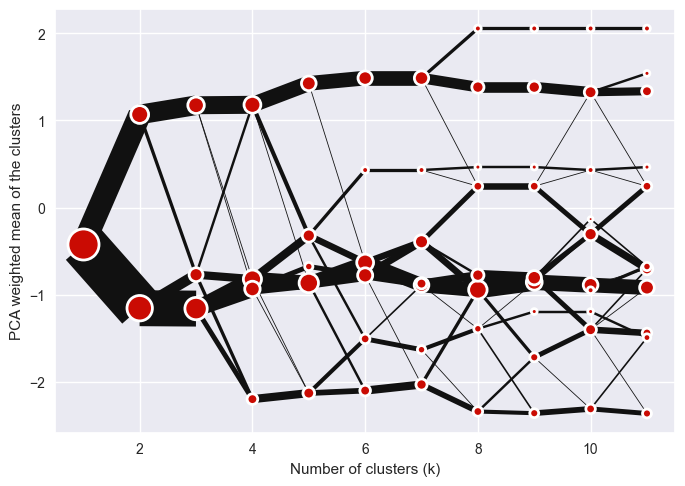

In [44]:
from clustergram import Clustergram

# задаем количество кластеров, для которого хотим получить визуализиацию
cgram = Clustergram(range(1, 12), method='kmeans')
# запускаем алгоритм
cgram.fit(tsne_data)
cgram.plot()

<Axes: xlabel='axis-1', ylabel='axis-2'>

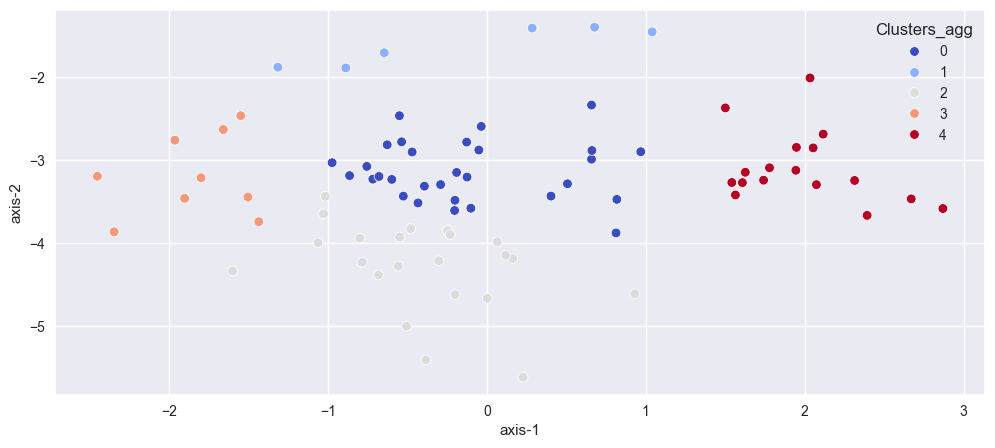

In [45]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=tsne_data, x='axis-1', y='axis-2', hue=model_data['Clusters_agg'], palette='coolwarm')

In [46]:
# Статистика по кластерам
cluster_profiles = model_data.iloc[:, 1:].groupby('Clusters_agg').median()
cluster_sizes = model_data.iloc[:, 1:]['Clusters_agg'].value_counts()

print("Размеры кластеров:")
print(cluster_sizes)

# Анализ наиболее проблемных регионов
poor_region = model_data[model_data['region'] == 'Республика Ингушетия'].index
poor_cluster = model_data.iloc[poor_region]['Clusters_agg'].values[0]
poor_regions = model_data[model_data['Clusters_agg'] == poor_cluster]

print(f"\nНаиболее проблемный кластер: {poor_cluster}")
print(f"Регионы в нем:\n{poor_regions['region']}")

Размеры кластеров:
Clusters_agg
0    30
2    23
4    17
3     9
1     6
Name: count, dtype: int64

Наиболее проблемный кластер: 3
Регионы в нем:
29                    Республика Адыгея
30                  Республика Калмыкия
38                 Республика Ингушетия
39      Кабардино-Балкарская Республика
40      Карачаево-Черкесская Республика
41    Республика Северная Осетия-Алания
42                 Чеченская Республика
65                      Республика Тыва
83         Еврейская автономная область
Name: region, dtype: object


In [47]:
# Сравнение с средними по стране
national_avg_income = numeric_data['income_2020'].median()
national_avg_poverty = numeric_data['poverty_2020'].median()
poor_regions_data = poor_regions.copy()

poor_regions_data['income_diff'] = (poor_regions_data['income_2020'] - national_avg_income) / national_avg_income * 100
poor_regions_data['poverty_diff'] = (poor_regions_data['poverty_2020'] - national_avg_poverty) / national_avg_poverty * 100

poor_regions_data[['region', 'income_diff', 'poverty_diff']]

,region,income_diff,poverty_diff
29,Республика Адыгея,5.934396,-3.846154
30,Республика Калмыкия,-30.721080,74.615385
38,Республика Ингушетия,-40.981256,130.769231
39,Кабардино-Балкарская Республика,-23.216534,86.153846
40,Карачаево-Черкесская Республика,-33.735487,78.461538
41,Республика Северная Осетия-Алания,-16.327458,6.923077
42,Чеченская Республика,-13.987970,56.923077
65,Республика Тыва,-33.655057,143.846154
83,Еврейская автономная область,-1.916352,81.538462


Агломеративный кластер выделил всего 9 бедных классов, убрав г. Севастополь из выборки, так как уровень бедности у него был низкий

In [ ]:
with open('model.pkl', 'wb') as output:
    pickle.dump(model_agg, output)

Standard output is empty
Standard error:
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.




RuntimeError: The SkLearn2PMML application has failed. The Java executable should have printed more information about the failure into its standard output and/or standard error streams

Сохраним модель Агломеративной кластеризации, как наиболее правдоподобную

In [66]:
model_data[['region', 'poverty_2020', 'Clusters_agg']].to_csv('../data/cluster_data.csv', index=False)

Также сохраним данные по кластеризации, для дальнейшего переиспользования